In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
seed = 7
thetas = np.linspace(0,1,100)
a = b = 2

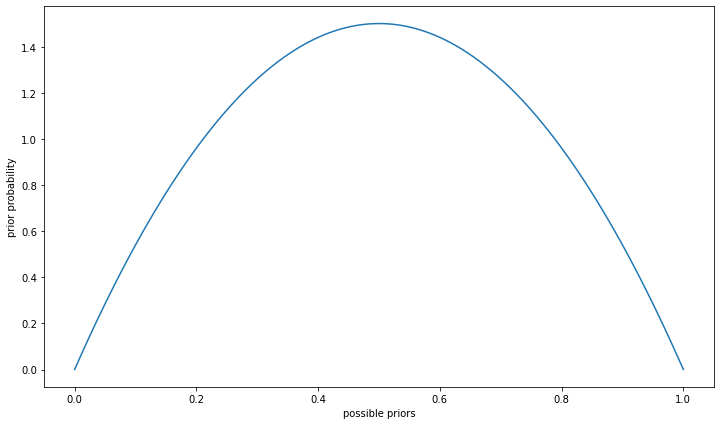

In [3]:
np.random.seed(seed)
prior = stats.beta(a,b).pdf(thetas)

plt.figure(figsize=(12, 7))
plt.plot(thetas, prior)
plt.xlabel('possible priors')
plt.ylabel('prior probability')
plt.show()

In [9]:
true_p = stats.beta.rvs(a, b)

print('true prior =', true_p)

x = stats.bernoulli.rvs(true_p, size=30)

print('x =', x)

true prior = 0.9077165921324053
x = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1]


In [10]:
import scipy.special as scf

# See https://en.wikipedia.org/wiki/Beta_distribution#Quantities_of_information_.28entropy.29
def KL(a2, b2, a1, b1):
    """Returns the Kullback-Leibler divergence between Beta[a2, b2] and Beta[a1, b1]"""
    return (np.log(scf.beta(a1, b1) / scf.beta(a2, b2)) + (a2 - a1) * scf.psi(a2) + (b2 - b1) * scf.psi(b2) +
            (a1 - a2 + b1 - b2) * scf.psi(a2 + b2))

# See https://en.wikipedia.org/wiki/Beta_distribution#Geometric_mean
def E_log_p_x_z(x, a2, b2):
    """Returns the expected value of log p(x | z) over z ~ Beta[a2, b2]"""
    return ((x == 1).sum() * (scf.psi(a2) - scf.psi(a2 + b2)) +
            (x == 0).sum() * (scf.psi(b2) - scf.psi(a2 + b2)))

In [11]:
import scipy.optimize as sco

def objective(a2b2):
    return (KL(a2b2[0], a2b2[1], a, b) - E_log_p_x_z(x, a2b2[0], a2b2[1]))

q_trace = [prior]

res = sco.minimize(objective, [a, b],
                   callback=lambda a2b2: q_trace.append(stats.beta(a2b2[0], a2b2[1]).pdf(thetas)))

print(res.message)
print(res.x)

Optimization terminated successfully.
[29.00056602  5.00008962]


In [12]:
import theano as th
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from lasagne.updates import rmsprop

In [13]:


def log_gaussian_logsigma(x, mu, logsigma):
    return -0.5 * np.log(2 * np.pi) - logsigma - (x - mu) ** 2 / (2. * T.exp(2. * logsigma))

def log_beta(x, a, b):
    return (a - 1) * T.log(x) + (b - 1) * T.log(1 - x) - (T.gammaln(a) + T.gammaln(b) - T.gammaln(a + b))

q_mu = th.shared(value=(float(a) / (a + b)), name='q_mu')

q_logsigma = th.shared(value=0.5 * np.log(float(a * b) /
                                          ((a + b)**2 * (a + b + 1))),
                       name='q_logsigma')

rs = RandomStreams(seed=733)

objective = 0.0
n_samples = 10
for sample in range(n_samples):
    eps = rs.normal([1], avg=0., std=1.)

    sample_z = (q_mu + T.exp(q_logsigma) * eps).clip(0 + 1e-6, 1 - 1e-6)

    sample_log_q_z = log_gaussian_logsigma(sample_z, q_mu, q_logsigma)

    sample_log_p_z = log_beta(sample_z, a, b)

    sample_log_p_x_z = (x == 1).sum() * T.log(sample_z) + (x == 0).sum() * T.log(1 - sample_z)

    objective += (sample_log_q_z - sample_log_p_z - sample_log_p_x_z).sum() / n_samples

updates = rmsprop(objective, [q_mu, q_logsigma], learning_rate=0.02)

optimize = th.function([], objective, updates=updates)

q_trace = [stats.norm(q_mu.get_value(), np.exp(q_logsigma.get_value())).pdf(thetas)]

for epoch in range(250):
    optimize()
    
    print('Epoch {0}: q ~ N[{1}, {2}]'.format(epoch, q_mu.get_value(), np.exp(q_logsigma.get_value())))
    
    q_trace.append(stats.norm(q_mu.get_value(), np.exp(q_logsigma.get_value())).pdf(thetas))

Epoch 0: q ~ N[0.5632455530663992, 0.20990265979136644]
Epoch 1: q ~ N[0.6077466181086782, 0.19781038914190052]
Epoch 2: q ~ N[0.6245121314404131, 0.197660203222397]
Epoch 3: q ~ N[0.6570309808944015, 0.18711393558703718]
Epoch 4: q ~ N[0.6769424007315715, 0.18693335827513924]
Epoch 5: q ~ N[0.69184517330968, 0.18592568266064396]
Epoch 6: q ~ N[0.7199993738001845, 0.17559010892652632]
Epoch 7: q ~ N[0.7272673171370516, 0.17134420529074698]
Epoch 8: q ~ N[0.7415402335767214, 0.17056066385166888]
Epoch 9: q ~ N[0.7612630065889894, 0.1686332409457451]
Epoch 10: q ~ N[0.7682708411866639, 0.16577168144405074]
Epoch 11: q ~ N[0.7700115868496165, 0.1638789229763896]
Epoch 12: q ~ N[0.7792944581751552, 0.1634152067448128]
Epoch 13: q ~ N[0.7651328259797188, 0.15760758121657237]
Epoch 14: q ~ N[0.7835853574481211, 0.15640590827796166]
Epoch 15: q ~ N[0.7968471331156858, 0.15293561714494786]
Epoch 16: q ~ N[0.8205000947414491, 0.15033797452805217]
Epoch 17: q ~ N[0.8369306442934045, 0.1498834089